# Land-Cover Classification with EuroSAT Dataset


![](https://raw.githubusercontent.com/phelber/EuroSAT/master/eurosat_overview_small.jpg) 



In this notebook we will tackle the problem of land-use and land-cover classification where we try to identify the class of given remote sensing image based on some well defined target class labels. For training the model we will use the EuroSAT dataset from this [paper](https://arxiv.org/abs/1709.00029) published in 2019 which is now a standard benchmark for land-cover classification task. 

This dataset consisits of 64x64 images captured by Sentinel-2A satellite and it has over **27000 images** spread across **10 classes**. Originally the data consists of hyperspectral images with 13 spectral bands but we will be working with only RGB channels downloaded from [here](http://madm.dfki.de/files/sentinel/EuroSAT.zip). 

The paper states that the finetuned CNN model **ResNet50** performed best with 80-20 split on the data for RGB channels giving about **98.57%** accuracy. 

Finally, this notebook was forked and edited from [here](https://www.kaggle.com/silentj23/eurosat-image-classification#II.-Preprocessing).

**NOTE:** This notebook is still a work in progress so expect a final version soon

In [1]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

# I. Data Exploration

In this project, I'll be exploring the EUROSAT dataset. The EUROSAT dataset is composed of images taken from the Sentinel-2 satellite. This dataset lists images of the earth's surface into 10 different land cover labels. For this project, I will build an image classification model for predicting a land cover label, given an image. 

In [2]:
DATASET = "../input/2750"

LABELS = os.listdir(DATASET)
print(LABELS)

['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']


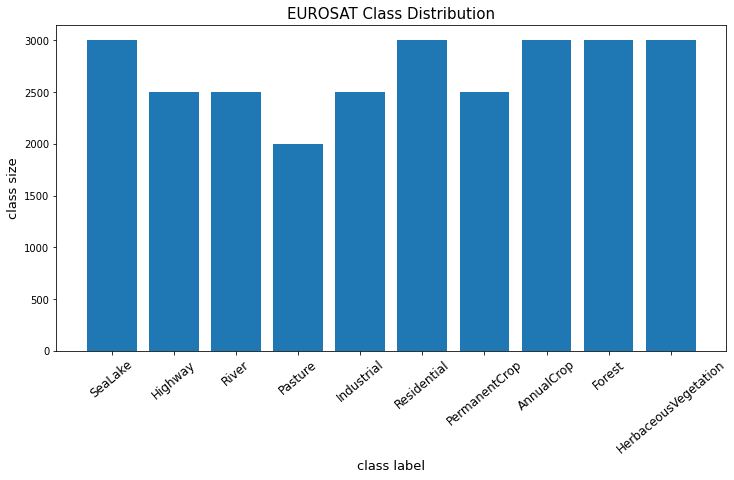

In [3]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

The dataset is split into 10 classes of land cover. Each class varies in size, so I'll have to stratify later on when splitting the data into training, testing and validation sets. 

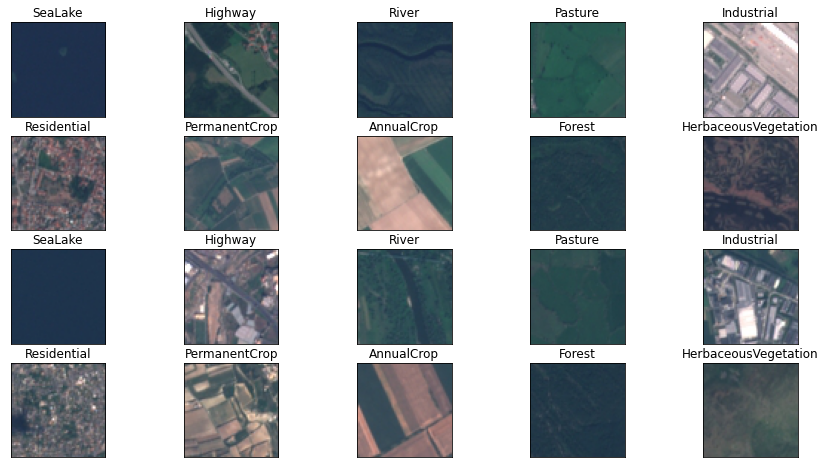

In [4]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

Looking at the preview of the different classes, we can see some similarities and stark differences between the classes. 

Urban environments such as Highway, Residential and Industrial images all contain structures and some roadways. 

AnnualCrops and PermanentCrops both feature agricultural land cover, with straight lines dilineating different crop fields. 

Finally, HerbaceaousVegetation, Pasture, and Forests feature natural land cover; Rivers also could be categorized as natural land cover as well, but may be easier to distinguish from the other natural classes.

If we consider the content of each image, we might be able to estimate which classes might be confused for each other. For example, an image of a river might be mistaken for a highway. Or an image of a highway junction, with surrounding buildings, could be mistaken for an Industrial site. We'll have to train a classifier powerful enough to differentiate these nuances. 

Sentinel-2 satellite images could also be downloaded with 10+ additional bands. Near-Infrared Radiation bands, for example, is a band of data that is available for this dataset. NIR can be used to create an index, visualising the radiation that is present (or not present) in a picture. This dataset does not contain the NIR wavelength bands, so this option will not be explored. But it's worth pointing out that this classification task could be addressed in another way using NIR data. 

# II. Preprocessing

I'd like to evaluate the performance of the model later on after training, so I'll perform a stratified shuffle-split using Scikit-learn to maintain class proportions. 30% of the dataset will be held for evaluation purposes. I'll be loading my data into the Keras model using the ImageDataGenerator class. I'll need the images to be in their own respective land cover directories. 

After splitting the dataset, I'll create some image augmentations using the generator and also denote a subset of the training data to be used as validation data during training. 

In [5]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '../working/training'
TEST_DIR = '../working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

Using TensorFlow backend.


In [6]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('\.\.\/input\/2750', '../working/training', i) for i in train_paths]
    new_test_paths = [re.sub('\.\.\/input\/2750', '../working/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

  0%|          | 33/21600 [00:00<01:05, 329.17it/s]

moving training files..


  1%|          | 39/5400 [00:00<00:13, 385.52it/s]

moving testing files..


100%|██████████| 5400/5400 [00:15<00:00, 350.26it/s]


In [7]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [8]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [9]:
np.save('class_indices', train_generator.class_indices)

# IV. Deep Learning For Image Classification

Deep Learning has highly influenced the field of computer vision when Convolutional Neural Networks (CNN) models were used in tasks like image classification, object detection, facial recognition etc. As discussed by authors of EuroSAT paper many deep learning models outperform the traditional non deep learning methods by a large margin. 

In this section we will train many state of the art architectures which performed well on the ILSVRC challenge. The authors achieved an accuracy of 98.57% using a fine tuned ResNet50 model. Here, I will try to employ a similar strategy for training the models where initially the CNN part of the model will be frozen with imagenet weights and dense layers will be trained with a high learning rate of 0.01 and later we will train the whole model end-to-end i.e. fine tune by keeping a small learning rate between 0.001 to 0.0001

Before we start here is a list of CNN models which we will train:
1. ResNet50
2. ResNet50V2
3. ResNet152V2
3. VGG16
4. VGG19

In future
5. InceptionV3
6. Xception

In [10]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16, VGG19
from keras.applications import ResNet50, ResNet50V2, ResNet152V2
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [12]:
# Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
       
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

In [13]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

## 4.1 ResNet50 Model

In [14]:
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet50_model.summary()

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 10s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________

In [15]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [16]:
# First Pretraining the dense layer
resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 44s 130ms/step - loss: 3.4273 - categorical_accuracy: 0.7109 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0995

Epoch 00001: val_categorical_accuracy improved from -inf to 0.09952, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 37s 109ms/step - loss: 0.9559 - categorical_accuracy: 0.7520 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0928

Epoch 00002: val_categorical_accuracy did not improve from 0.09952
Epoch 3/50
337/337 [==============================] - 37s 108ms/step - loss: 0.9515 - categorical_accuracy: 0.7534 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0928

Epoch 00003: val_categorical_accuracy did not improve from 0.09952
Epoch 4/50
337/337 [==============================] - 36s 107ms/step - loss: 0.9692 - categorical_accuracy: 0.7552 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0928

Epoch 00004: val_categorical_accuracy did not impr

In [17]:
# re-train whole network end2end 
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/100
337/337 [==============================] - 78s 232ms/step - loss: 0.8400 - categorical_accuracy: 0.7818 - val_loss: 3.2587 - val_categorical_accuracy: 0.1001

Epoch 00001: val_categorical_accuracy did not improve from 0.10476
Epoch 2/100
337/337 [==============================] - 53s 158ms/step - loss: 0.5472 - categorical_accuracy: 0.8594 - val_loss: 3.0749e-06 - val_categorical_accuracy: 0.0997

Epoch 00002: val_categorical_accuracy did not improve from 0.10476
Epoch 3/100
337/337 [==============================] - 53s 157ms/step - loss: 0.4220 - categorical_accuracy: 0.8915 - val_loss: 0.0685 - val_categorical_accuracy: 0.5075

Epoch 00003: val_categorical_accuracy improved from 0.10476 to 0.50750, saving model to ../working/model.weights.best.hdf5
Epoch 4/100
337/337 [==============================] - 53s 156ms/step - loss: 0.3684 - categorical_accuracy: 0.8923 - val_loss: 0.5975 - val_categorical_accuracy: 0.8924

Epoch 00004: val_categorical_accuracy improved from 0.5

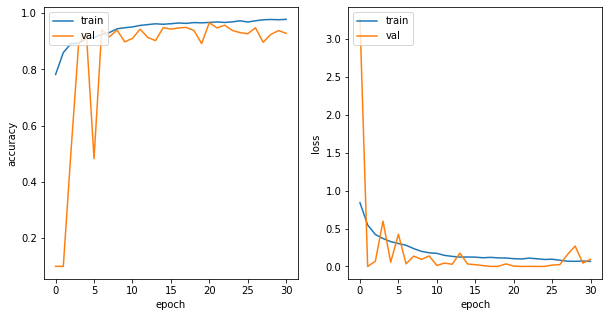

In [18]:
plot_history(resnet50_history)

In [19]:
resnet50_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9653703703703703
Global F2 Score: 0.9653703703703703


,Precision,Recall,F-Score,Support
AnnualCrop,0.941456,0.947452,0.944444,628.0
Forest,0.971014,1.000000,0.985294,603.0
HerbaceousVegetation,0.971731,0.945017,0.958188,582.0
Highway,0.980769,0.947955,0.964083,538.0
Industrial,0.972043,0.918699,0.944619,492.0
Pasture,0.978437,0.960317,0.969292,378.0
PermanentCrop,0.920160,0.960417,0.939857,480.0
Residential,0.966616,0.996870,0.981510,639.0
River,0.959064,0.982036,0.970414,501.0
SeaLake,0.996377,0.983900,0.990099,559.0


In [20]:
# Save the model and the weights
resnet50_model.save('../working/ResNet50_eurosat.h5')

## 4.2 ResNet50V2 Model

In [21]:
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet50V2_model.summary()

94674944/94668760 [==============================] - 8s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
___________________________

In [22]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [23]:
# First Pretraining the dense layer
resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 39s 116ms/step - loss: 2.7719 - categorical_accuracy: 0.5744 - val_loss: 0.3108 - val_categorical_accuracy: 0.3597

Epoch 00001: val_categorical_accuracy improved from -inf to 0.35975, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 36s 107ms/step - loss: 1.4427 - categorical_accuracy: 0.6126 - val_loss: 0.2514 - val_categorical_accuracy: 0.4496

Epoch 00002: val_categorical_accuracy improved from 0.35975 to 0.44959, saving model to ../working/model.weights.best.hdf5
Epoch 3/50
337/337 [==============================] - 36s 107ms/step - loss: 1.4228 - categorical_accuracy: 0.6144 - val_loss: 1.2341 - val_categorical_accuracy: 0.4102

Epoch 00003: val_categorical_accuracy did not improve from 0.44959
Epoch 4/50
337/337 [==============================] - 36s 108ms/step - loss: 1.4118 - categorical_accuracy: 0.6200 - val_loss: 0.4796 - val_categorical_accuracy: 0.4162

Epoch 0000

In [24]:
# re-train whole network end2end 
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50V2_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
337/337 [==============================] - 71s 211ms/step - loss: 0.8410 - categorical_accuracy: 0.7498 - val_loss: 0.0470 - val_categorical_accuracy: 0.8341

Epoch 00001: val_categorical_accuracy improved from 0.44959 to 0.83408, saving model to ../working/model.weights.best.hdf5
Epoch 2/100
337/337 [==============================] - 51s 150ms/step - loss: 0.4831 - categorical_accuracy: 0.8541 - val_loss: 0.0320 - val_categorical_accuracy: 0.9074

Epoch 00002: val_categorical_accuracy improved from 0.83408 to 0.90742, saving model to ../working/model.weights.best.hdf5
Epoch 3/100
337/337 [==============================] - 52s 153ms/step - loss: 0.3664 - categorical_accuracy: 0.8883 - val_loss: 0.4808 - val_categorical_accuracy: 0.9042

Epoch 00003: val_categorical_accuracy did not improve from 0.90742
Epoch 4/100
337/337 [==============================] - 51s 152ms/step - loss: 0.3099 - categorical_accuracy: 0.9060 - val_loss: 0.3719 - val_categorical_accuracy: 0.9155

Epo

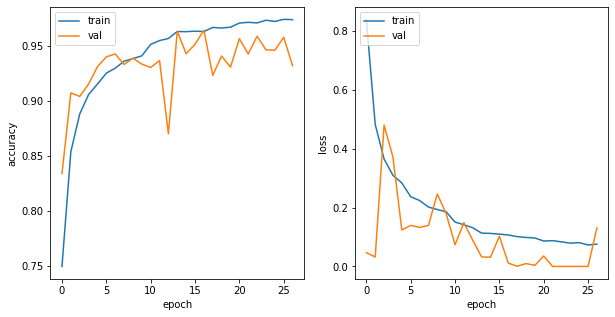

In [25]:
plot_history(resnet50V2_history)

In [26]:
resnet50V2_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50V2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9631481481481482
Global F2 Score: 0.9631481481481482


,Precision,Recall,F-Score,Support
AnnualCrop,0.952607,0.960191,0.956384,628.0
Forest,0.977236,0.996683,0.986864,603.0
HerbaceousVegetation,0.941275,0.963918,0.952462,582.0
Highway,0.959302,0.920074,0.939279,538.0
Industrial,0.959514,0.963415,0.961460,492.0
Pasture,0.975806,0.960317,0.968000,378.0
PermanentCrop,0.944568,0.887500,0.915145,480.0
Residential,0.965099,0.995305,0.979969,639.0
River,0.956947,0.976048,0.966403,501.0
SeaLake,1.000000,0.989267,0.994604,559.0


In [27]:
# Save the model and the weights
resnet50V2_model.save('../working/ResNet50V2_eurosat.h5')

## 4.3 ResNet152V2 Model

In [28]:
resnet152V2_model = compile_model('ResNet152V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet152V2_model.summary()

234553344/234545216 [==============================] - 43s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
________________________

In [29]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [30]:
# First Pretraining the dense layer
resnet152V2_history = resnet152V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 56s 167ms/step - loss: 2.6878 - categorical_accuracy: 0.5677 - val_loss: 1.3035 - val_categorical_accuracy: 0.3958

Epoch 00001: val_categorical_accuracy improved from -inf to 0.39583, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 44s 132ms/step - loss: 1.4106 - categorical_accuracy: 0.6093 - val_loss: 0.9082 - val_categorical_accuracy: 0.3883

Epoch 00002: val_categorical_accuracy did not improve from 0.39583
Epoch 3/50
337/337 [==============================] - 44s 131ms/step - loss: 1.4310 - categorical_accuracy: 0.6094 - val_loss: 1.1775 - val_categorical_accuracy: 0.3846

Epoch 00003: val_categorical_accuracy did not improve from 0.39583
Epoch 4/50
337/337 [==============================] - 44s 131ms/step - loss: 1.4090 - categorical_accuracy: 0.6098 - val_loss: 1.0702 - val_categorical_accuracy: 0.4174

Epoch 00004: val_categorical_accuracy improved from 0.39583 to 0.4

In [31]:
# re-train whole network end2end 
resnet152V2_model = compile_model('ResNet152V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet152V2_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet152V2_history = resnet152V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
337/337 [==============================] - 222s 658ms/step - loss: 1.0623 - categorical_accuracy: 0.7016 - val_loss: 1.0566 - val_categorical_accuracy: 0.7783

Epoch 00001: val_categorical_accuracy improved from 0.42448 to 0.77827, saving model to ../working/model.weights.best.hdf5
Epoch 2/100
337/337 [==============================] - 121s 359ms/step - loss: 0.5924 - categorical_accuracy: 0.8280 - val_loss: 0.3417 - val_categorical_accuracy: 0.8557

Epoch 00002: val_categorical_accuracy improved from 0.77827 to 0.85570, saving model to ../working/model.weights.best.hdf5
Epoch 3/100
337/337 [==============================] - 122s 361ms/step - loss: 0.5028 - categorical_accuracy: 0.8563 - val_loss: 0.0359 - val_categorical_accuracy: 0.9091

Epoch 00003: val_categorical_accuracy improved from 0.85570 to 0.90911, saving model to ../working/model.weights.best.hdf5
Epoch 4/100
337/337 [==============================] - 120s 357ms/step - loss: 0.3789 - categorical_accuracy: 0.889

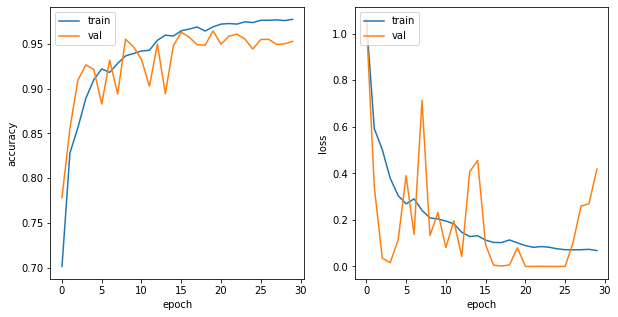

In [32]:
plot_history(resnet152V2_history)

In [33]:
resnet152V2_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet152V2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9635185185185186
Global F2 Score: 0.9635185185185186


,Precision,Recall,F-Score,Support
AnnualCrop,0.945946,0.947452,0.946698,628.0
Forest,0.978723,0.991708,0.985173,603.0
HerbaceousVegetation,0.968421,0.948454,0.958333,582.0
Highway,0.965779,0.944238,0.954887,538.0
Industrial,0.972689,0.941057,0.956612,492.0
Pasture,0.970027,0.941799,0.955705,378.0
PermanentCrop,0.934292,0.947917,0.941055,480.0
Residential,0.939528,0.996870,0.967350,639.0
River,0.968254,0.974052,0.971144,501.0
SeaLake,0.998188,0.985689,0.991899,559.0


In [34]:
# Save the model and the weights
resnet152V2_model.save('../working/ResNet152V2_eurosat.h5')

## 4.4 VGG16 Model

In [35]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg16_model.summary()

58892288/58889256 [==============================] - 10s 0us/step
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
___________________________________________________________

In [36]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [37]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 35s 103ms/step - loss: 1.7926 - categorical_accuracy: 0.5331 - val_loss: 0.1613 - val_categorical_accuracy: 0.6983

Epoch 00001: val_categorical_accuracy improved from -inf to 0.69829, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 35s 103ms/step - loss: 1.1009 - categorical_accuracy: 0.6129 - val_loss: 0.8347 - val_categorical_accuracy: 0.7007

Epoch 00002: val_categorical_accuracy improved from 0.69829 to 0.70071, saving model to ../working/model.weights.best.hdf5
Epoch 3/50
337/337 [==============================] - 35s 103ms/step - loss: 1.0591 - categorical_accuracy: 0.6351 - val_loss: 0.3630 - val_categorical_accuracy: 0.7369

Epoch 00003: val_categorical_accuracy improved from 0.70071 to 0.73688, saving model to ../working/model.weights.best.hdf5
Epoch 4/50
337/337 [==============================] - 34s 102ms/step - loss: 1.0152 - categorical_accuracy: 0.6477 - val_los

In [38]:
# re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

vgg16_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
337/337 [==============================] - 39s 116ms/step - loss: 1.4594 - categorical_accuracy: 0.5118 - val_loss: 0.3164 - val_categorical_accuracy: 0.7666

Epoch 00001: val_categorical_accuracy did not improve from 0.81559
Epoch 2/100
337/337 [==============================] - 38s 113ms/step - loss: 0.7213 - categorical_accuracy: 0.7648 - val_loss: 0.3029 - val_categorical_accuracy: 0.8478

Epoch 00002: val_categorical_accuracy improved from 0.81559 to 0.84783, saving model to ../working/model.weights.best.hdf5
Epoch 3/100
337/337 [==============================] - 38s 114ms/step - loss: 0.5533 - categorical_accuracy: 0.8334 - val_loss: 0.2194 - val_categorical_accuracy: 0.8296

Epoch 00003: val_categorical_accuracy did not improve from 0.84783
Epoch 4/100
337/337 [==============================] - 38s 113ms/step - loss: 0.3935 - categorical_accuracy: 0.8878 - val_loss: 0.2968 - val_categorical_accuracy: 0.9151

Epoch 00004: val_categorical_accuracy improved from 0.84783

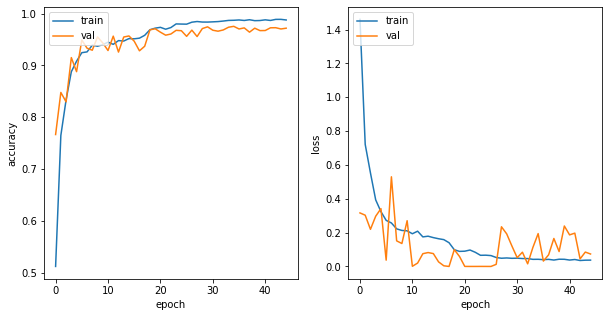

In [39]:
plot_history(vgg16_history)

In [40]:
vgg16_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.975
Global F2 Score: 0.975


,Precision,Recall,F-Score,Support
AnnualCrop,0.974194,0.961783,0.967949,628.0
Forest,0.972581,1.000000,0.986100,603.0
HerbaceousVegetation,0.977312,0.962199,0.969697,582.0
Highway,0.988593,0.966543,0.977444,538.0
Industrial,0.969450,0.967480,0.968464,492.0
Pasture,0.983651,0.955026,0.969128,378.0
PermanentCrop,0.951782,0.945833,0.948798,480.0
Residential,0.963801,1.000000,0.981567,639.0
River,0.970646,0.990020,0.980237,501.0
SeaLake,1.000000,0.987478,0.993699,559.0


In [41]:
# Save the model and the weights
vgg16_model.save('../working/vgg16_eurosat.h5')

## 4.5 VGG19 Model

In [42]:
vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg19_model.summary()

80142336/80134624 [==============================] - 18s 0us/step
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
___________________________________________________________

In [43]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [44]:
train_generator.reset()
# First Pretraining the dense layer
vgg19_history = vgg19_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 35s 103ms/step - loss: 1.9849 - categorical_accuracy: 0.4792 - val_loss: 1.0597 - val_categorical_accuracy: 0.5690

Epoch 00001: val_categorical_accuracy improved from -inf to 0.56901, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 35s 103ms/step - loss: 1.2697 - categorical_accuracy: 0.5433 - val_loss: 0.6963 - val_categorical_accuracy: 0.5804

Epoch 00002: val_categorical_accuracy improved from 0.56901 to 0.58040, saving model to ../working/model.weights.best.hdf5
Epoch 3/50
337/337 [==============================] - 36s 105ms/step - loss: 1.1922 - categorical_accuracy: 0.5770 - val_loss: 0.7018 - val_categorical_accuracy: 0.6627

Epoch 00003: val_categorical_accuracy improved from 0.58040 to 0.66267, saving model to ../working/model.weights.best.hdf5
Epoch 4/50
337/337 [==============================] - 35s 104ms/step - loss: 1.1850 - categorical_accuracy: 0.5794 - val_los

In [45]:
# re-train whole network end2end 
vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

vgg19_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg19_history = vgg19_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
337/337 [==============================] - 40s 120ms/step - loss: 3.6070 - categorical_accuracy: 0.1127 - val_loss: 2.2657 - val_categorical_accuracy: 0.1122

Epoch 00001: val_categorical_accuracy did not improve from 0.73482
Epoch 2/100
337/337 [==============================] - 39s 117ms/step - loss: 2.9885 - categorical_accuracy: 0.1114 - val_loss: 2.1396 - val_categorical_accuracy: 0.1130

Epoch 00002: val_categorical_accuracy did not improve from 0.73482
Epoch 3/100
337/337 [==============================] - 39s 117ms/step - loss: 2.6678 - categorical_accuracy: 0.1104 - val_loss: 2.1854 - val_categorical_accuracy: 0.1130

Epoch 00003: val_categorical_accuracy did not improve from 0.73482
Epoch 4/100
337/337 [==============================] - 39s 117ms/step - loss: 2.4852 - categorical_accuracy: 0.1116 - val_loss: 2.2262 - val_categorical_accuracy: 0.1130

Epoch 00004: val_categorical_accuracy did not improve from 0.73482
Epoch 5/100
337/337 [===========================

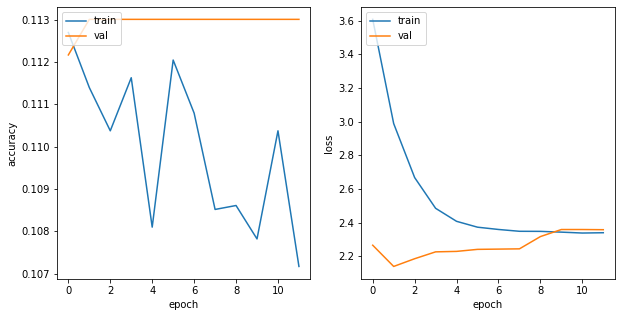

In [46]:
plot_history(vgg19_history)

In [47]:
vgg19_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg19_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.6085185185185186
Global F2 Score: 0.6085185185185186


,Precision,Recall,F-Score,Support
AnnualCrop,0.264321,0.933121,0.411951,628.0
Forest,0.905861,0.845771,0.874786,603.0
HerbaceousVegetation,0.807818,0.426117,0.557930,582.0
Highway,0.950000,0.105948,0.190635,538.0
Industrial,0.833652,0.886179,0.859113,492.0
Pasture,0.697561,0.378307,0.490566,378.0
PermanentCrop,0.729958,0.360417,0.482566,480.0
Residential,0.876897,0.813772,0.844156,639.0
River,0.663212,0.255489,0.368876,501.0
SeaLake,0.966135,0.867621,0.914232,559.0


In [48]:
# Save the model and the weights
vgg19_model.save('../working/vgg19_eurosat.h5')

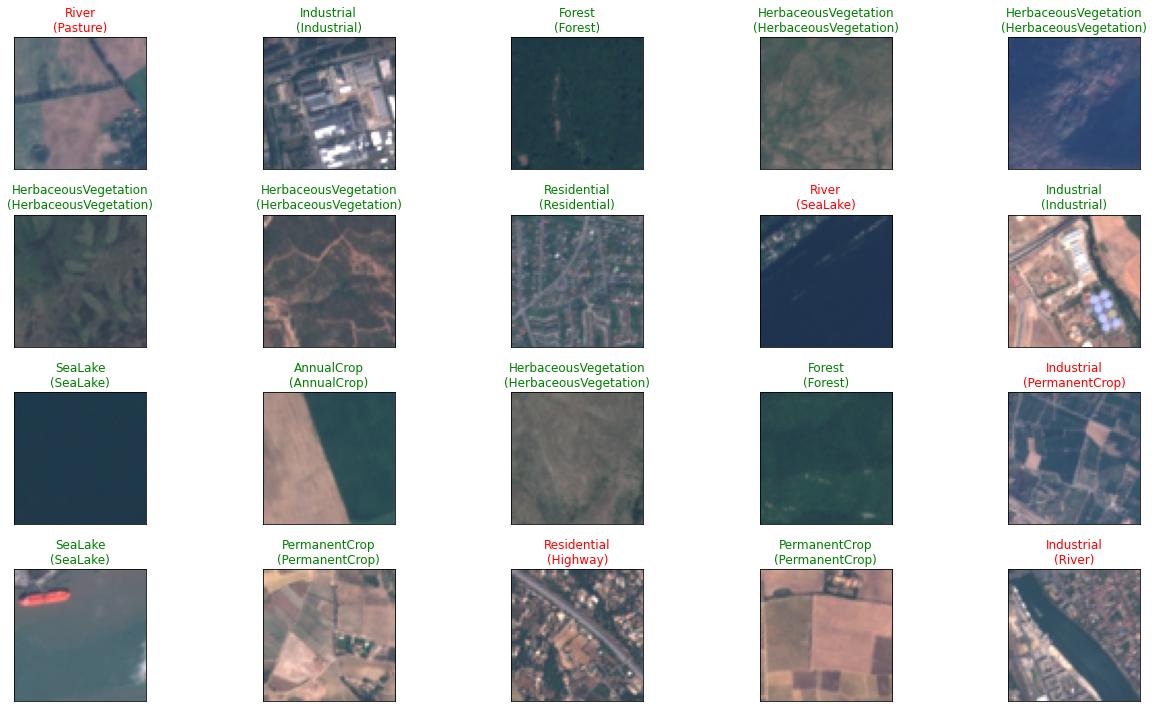

In [49]:
plot_predictions(true_classes, predictions, test_generator_new, class_indices)